# Labs : Proximal coordinate descent method on regression models



## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$



In [1]:
# Change here using YOUR first and last names
fn1 = "daniel"
ln1 = "wamo"
fn2 = "samuel"
ln2 = "guilhem-ducléon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_wamo_daniel_and_guilhem-ducléon_samuel.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

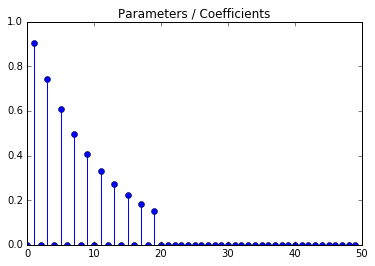

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

- Question: Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases

In [24]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""
    ret = np.multiply(np.sign(x), np.maximum(0, (np.absolute(x) - s*t )))
    
    return ret
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    ret = s * np.linalg.norm(x, 1)
    
    return ret

def prox_indicator(x, s, t=1.):
    """Proximal operator for the indicator function of R+ at x with strength t"""
    return np.maximum(x, 0)

def indicator(x, s):
    """Value of the indicator function of R+ at x"""
    if (x < 0).any():
        return np.inf
    else:
        return 0
    

- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

f is convex and differentiable.

Moreover, the non-smooth part (g) is separable here for both functions: lasso and indicator of R+.

- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.

In [25]:
import random

def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    r = b - A.dot(x)
    tmp = 0
    
    for k in range(n_iter + 1):

        x_new = x.copy()
        
        i = random.randint(0, n_features - 1)
        
        L_i = A[:, i].T.dot(A[:, i])
        gamma_i = 1./L_i
        
        x_new[i] = prox_g(x[i] + gamma_i*(A[:,i].T.dot(r)), s, gamma_i)
        
        
        r = r + A[:,i]*(x[i] - x_new[i]) # update r

        x = x_new
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [26]:
A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)

Let's run the algorithm with the Lasso penalization.

In [28]:
s = 1e-2
n_iter = 1000

g = lasso
prox_g = prox_lasso

x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s=s, n_iter=n_iter, x_true=coefs, verbose=True)

Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.20e+03 | 1.00e+00
      10 | 1.87e+03 | 1.12e+00
      20 | 1.69e+03 | 1.06e+00
      30 | 1.50e+03 | 1.12e+00
      40 | 8.09e+02 | 8.37e-01
      50 | 7.85e+02 | 7.81e-01
      60 | 7.30e+02 | 7.17e-01
      70 | 7.10e+02 | 6.94e-01
      80 | 7.05e+02 | 6.91e-01
      90 | 5.89e+02 | 5.44e-01
     100 | 5.76e+02 | 5.10e-01
     110 | 5.60e+02 | 4.85e-01
     120 | 5.56e+02 | 4.80e-01
     130 | 5.51e+02 | 4.70e-01
     140 | 5.50e+02 | 4.68e-01
     150 | 5.35e+02 | 4.30e-01
     160 | 5.29e+02 | 4.18e-01
     170 | 5.17e+02 | 3.81e-01
     180 | 5.17e+02 | 3.77e-01
     190 | 5.06e+02 | 3.39e-01
     200 | 5.06e+02 | 3.42e-01
     210 | 5.01e+02 | 3.23e-01
     220 | 5.00e+02 | 3.24e-01
     230 | 4.82e+02 | 2.76e-01
     240 | 4.82e+02 | 2.78e-01
     250 | 4.80e+02 | 2.78e-01
     260 | 4.79e+02 | 2.72e-01
     270 | 4.76e+02 | 2.68e-01
     280 | 4.75e+02 | 2.65e-01
     290 | 4.75e+02 | 2.66e-01
 

Let's now run the algorithm using the indicator of $\mathbb{R}+$ as a penalization.

In [30]:
s = 1e-2
n_iter = 1000

g = indicator
prox_g = prox_indicator

x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s=s, n_iter=n_iter, x_true=coefs, verbose=True)

Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 2.20e+03 | 1.00e+00
      10 | 1.36e+03 | 9.55e-01
      20 | 1.32e+03 | 9.46e-01
      30 | 1.32e+03 | 9.20e-01
      40 | 9.97e+02 | 8.70e-01
      50 | 8.67e+02 | 8.51e-01
      60 | 8.59e+02 | 8.52e-01
      70 | 8.19e+02 | 8.27e-01
      80 | 8.03e+02 | 8.12e-01
      90 | 7.87e+02 | 8.03e-01
     100 | 7.58e+02 | 7.51e-01
     110 | 7.53e+02 | 7.44e-01
     120 | 7.44e+02 | 7.25e-01
     130 | 7.40e+02 | 7.23e-01
     140 | 7.39e+02 | 7.22e-01
     150 | 7.37e+02 | 7.21e-01
     160 | 6.40e+02 | 5.85e-01
     170 | 6.27e+02 | 5.54e-01
     180 | 6.19e+02 | 5.58e-01
     190 | 6.19e+02 | 5.58e-01
     200 | 5.99e+02 | 5.56e-01
     210 | 5.95e+02 | 5.39e-01
     220 | 5.94e+02 | 5.39e-01
     230 | 5.68e+02 | 4.84e-01
     240 | 5.68e+02 | 4.76e-01
     250 | 5.11e+02 | 3.49e-01
     260 | 5.08e+02 | 3.42e-01
     270 | 5.08e+02 | 3.40e-01
     280 | 5.08e+02 | 3.40e-01
     290 | 5.06e+02 | 3.33e-01
 

- Question: evaluate qualitatively the convergence when varying the conditioning of the problem.

To vary the conditioning of the problem we need to vary the s factor and see the influence on the convergence.

In [31]:
s = 1e10
n_iter = 1000

g = indicator
prox_g = prox_indicator

x, objectives, errors = cd_linreg(x0, A, b, g, prox_g, s=s, n_iter=n_iter, x_true=coefs, verbose=True)

Lauching Coordinate Descent solver...
   it    |   obj    |   err   
       0 | 1.91e+03 | 1.12e+00
      10 | 1.77e+03 | 1.17e+00
      20 | 1.61e+03 | 1.21e+00
      30 | 1.56e+03 | 1.22e+00
      40 | 1.19e+03 | 1.06e+00
      50 | 1.15e+03 | 1.08e+00
      60 | 8.83e+02 | 8.68e-01
      70 | 7.77e+02 | 7.92e-01
      80 | 6.85e+02 | 6.99e-01
      90 | 6.79e+02 | 6.95e-01
     100 | 6.67e+02 | 6.88e-01
     110 | 6.67e+02 | 6.86e-01
     120 | 6.65e+02 | 6.85e-01
     130 | 6.04e+02 | 5.73e-01
     140 | 5.62e+02 | 4.61e-01
     150 | 5.60e+02 | 4.56e-01
     160 | 5.56e+02 | 4.46e-01
     170 | 5.49e+02 | 4.17e-01
     180 | 5.31e+02 | 3.90e-01
     190 | 5.08e+02 | 3.45e-01
     200 | 5.07e+02 | 3.40e-01
     210 | 5.07e+02 | 3.39e-01
     220 | 4.96e+02 | 2.95e-01
     230 | 4.96e+02 | 2.94e-01
     240 | 4.87e+02 | 2.57e-01
     250 | 4.85e+02 | 2.45e-01
     260 | 4.83e+02 | 2.41e-01
     270 | 4.81e+02 | 2.32e-01
     280 | 4.80e+02 | 2.25e-01
     290 | 4.75e+02 | 1.92e-01
 

With $s = 10^{-2}$ the algorithm with the second penalty converges in roughly 480 iterations.

With $s = 10^{-5}$ the same algorithm converges in roughly 860 iterations.

With $s = 1$ the same algorithm converges in 370 iterations approximately.

We can deduce that increasing s makes the convergence faster. If s is too small, the convergence can be very slow. However, if s is too large, the convergence is less accurate and the function might find a worse local minimum as the step is too large and not accurate enough.

We can draw the same conclusions with the lasso penalization.

- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

Let's vary the s coefficient in the algorithm from the previous lab session.

With $s = 10^{-2}$ the algorithm of coordinate descent with the lasso penalty converges in roughly 20 iterations.


With $s = 10^{-5}$ the same algorithm converges in also 20 iterations approximately but finds a better minimum.

With $s = 1$ the same algorithm converges in 10 iterations approximately but finds a worse minimum than with $s = 10^{-2}$.


Bad conditioning on coordinate descent does not affect the rate of convergence substantially. Concerning ISTA, a $O(\frac{1}{k})$ convergence is guaranteed. For FISTA, a $O(\frac{1}{k^2})$ convergence is guaranteed. The only risk is to get a worse minimum with a bad conditioning.